## Jupyter Notebook to get visualizations of the Experiment on the Evaluation of local AI models in therapeutic settings

### Import necessary packages

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import json
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

### Load results and set up directories to save the visualizations to

In [14]:
# Load the dataset
df = pd.read_csv("combined_model_comparison.csv")
df['model'] = df['model_name'].apply(lambda x: x.split('/')[-1])

overall_images_dir = "overall_images"
os.makedirs(overall_images_dir, exist_ok= True)
context_comparison_dir = "context_comparison"
os.makedirs(context_comparison_dir, exist_ok=True)
weighted_Context_dir = "weighted_Context"
os.makedirs(weighted_Context_dir, exist_ok=True)
human_variability_dir = "human_variability"
os.makedirs(human_variability_dir, exist_ok=True)

#### First, overall results comparing the models

#### Boxplot: Cosine Similarity per Model (not weighted on frequency of contexts)

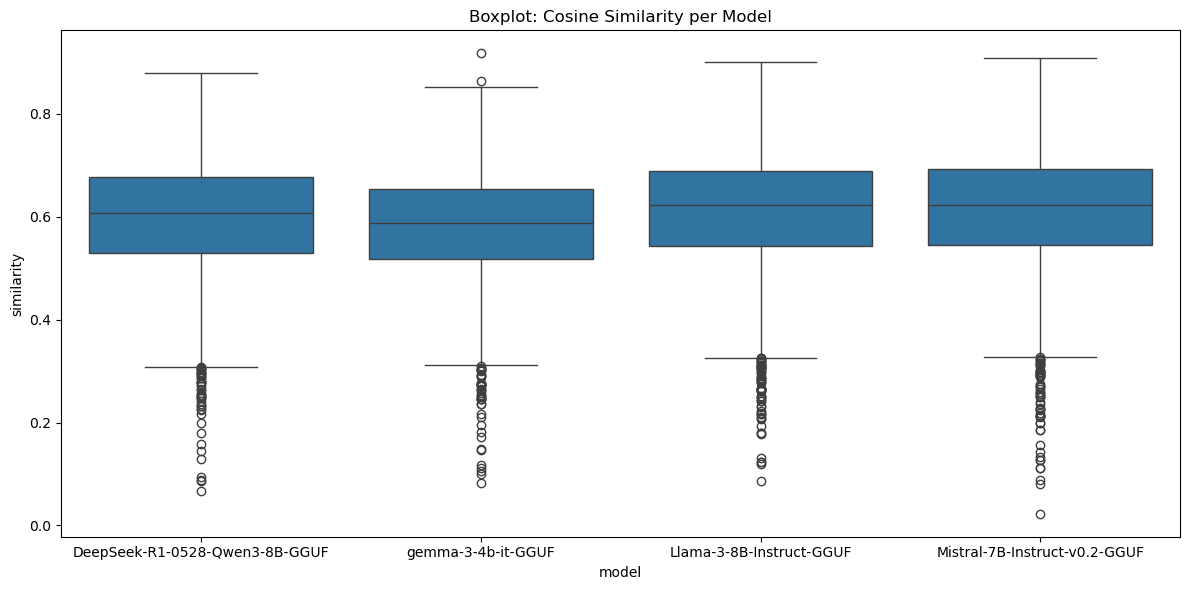

In [10]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='model', y='similarity')
plt.title("Boxplot: Cosine Similarity per Model")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(overall_images_dir, "boxplot_similarity.png"))
plt.show()
plt.close()

#### Barplot: Mean Similarity with Standard Deviation per model (not weighted on frequency of contexts)

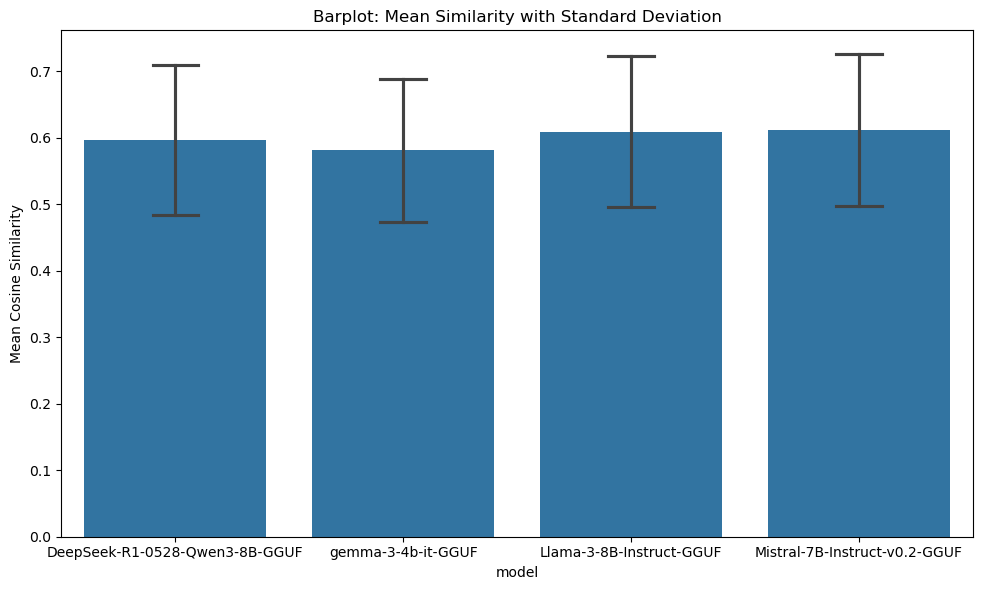

In [11]:
model_stats = df.groupby('model')['similarity'].agg(['mean', 'std']).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='model', y='similarity', errorbar="sd", capsize=0.2)
plt.title("Barplot: Mean Similarity with Standard Deviation")
plt.ylabel("Mean Cosine Similarity")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(overall_images_dir, "barplot_mean_std.png"))
plt.show()
plt.close()

#### Violin Plot: Similarities per model (not weighted on frequency of contexts)

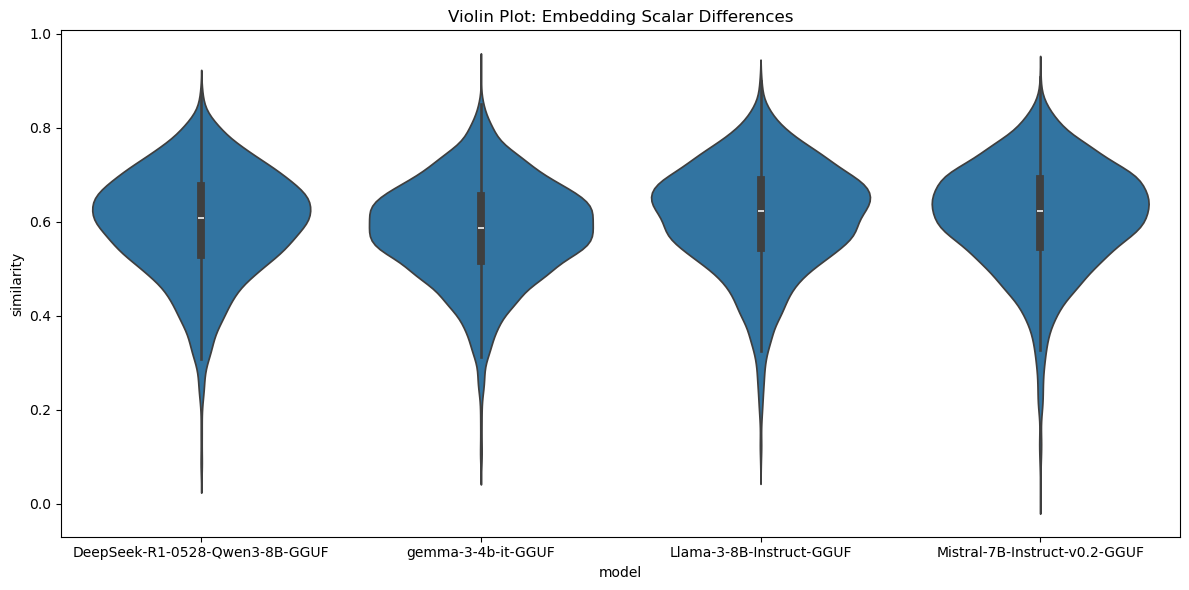

In [12]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='model', y='similarity')
plt.title("Violin Plot: Embedding Scalar Differences")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(overall_images_dir, "violin_similarities.png"))
plt.show()
plt.close()

#### KDE Plot: Similarity Density per Model

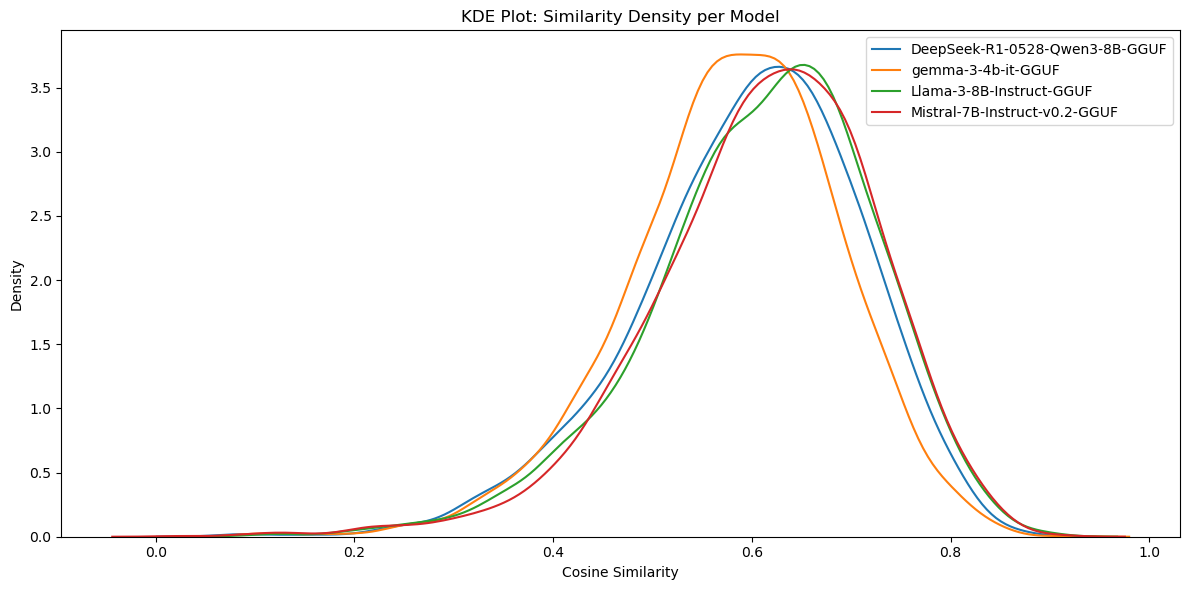

In [13]:
plt.figure(figsize=(12, 6))
for model in df['model'].unique():
    sns.kdeplot(df[df['model'] == model]['similarity'], label=model)
plt.title("KDE Plot: Similarity Density per Model")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(overall_images_dir, "kde_similarity.png"))
plt.show()
plt.close()

#### Violin Plot: Embedding Scalar Differences per model

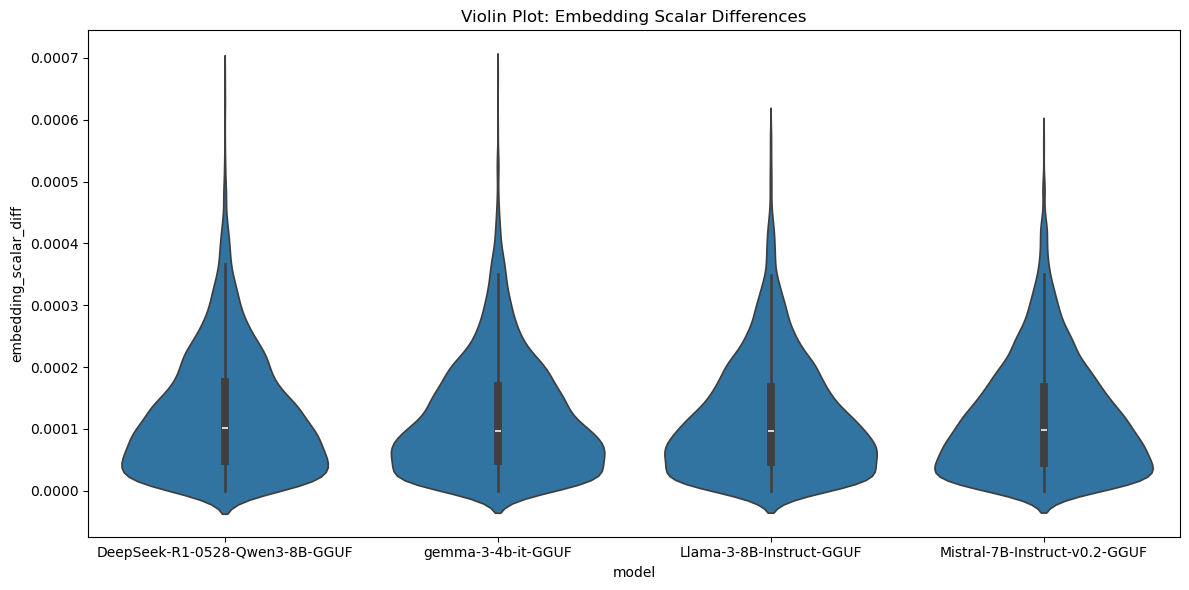

In [14]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='model', y='embedding_scalar_diff')
plt.title("Violin Plot: Embedding Scalar Differences")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(overall_images_dir, "violin_scalar_diff.png"))
plt.show()
plt.close()

#### Histogram: Scalar Differences per Model

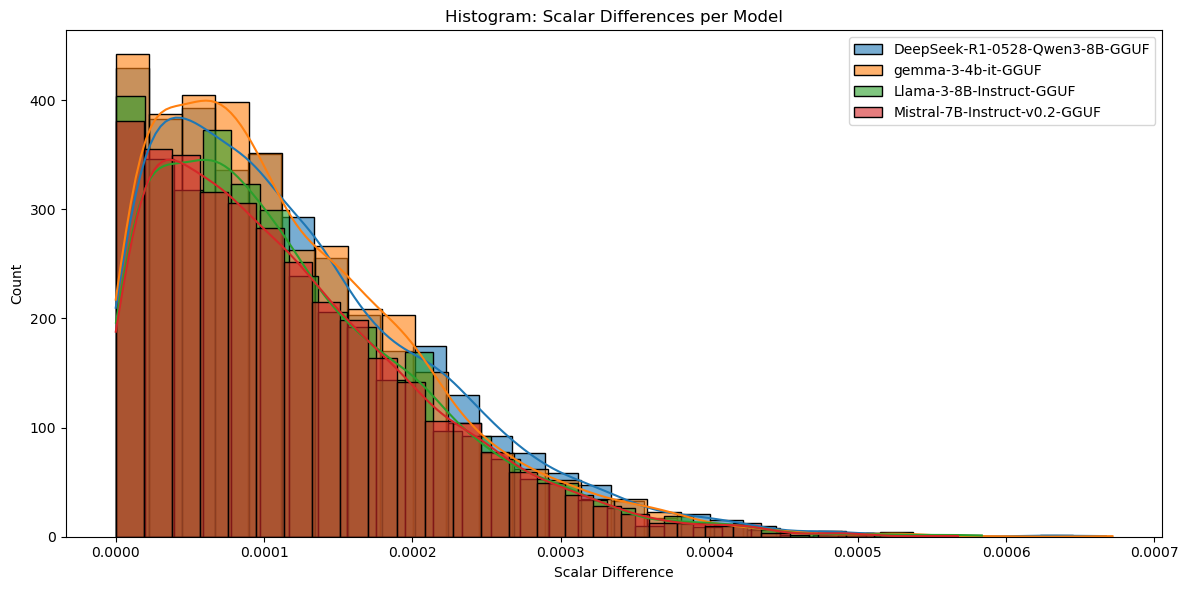

In [15]:
plt.figure(figsize=(12, 6))
for model in df['model'].unique():
    subset = df[df['model'] == model]
    sns.histplot(subset['embedding_scalar_diff'], kde=True, label=model, bins=30, alpha=0.6)
plt.title("Histogram: Scalar Differences per Model")
plt.xlabel("Scalar Difference")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(overall_images_dir, "hist_scalar_diff.png"))
plt.show()
plt.close()

#### Optional: PCA Scatterplot of Embedding Scalars

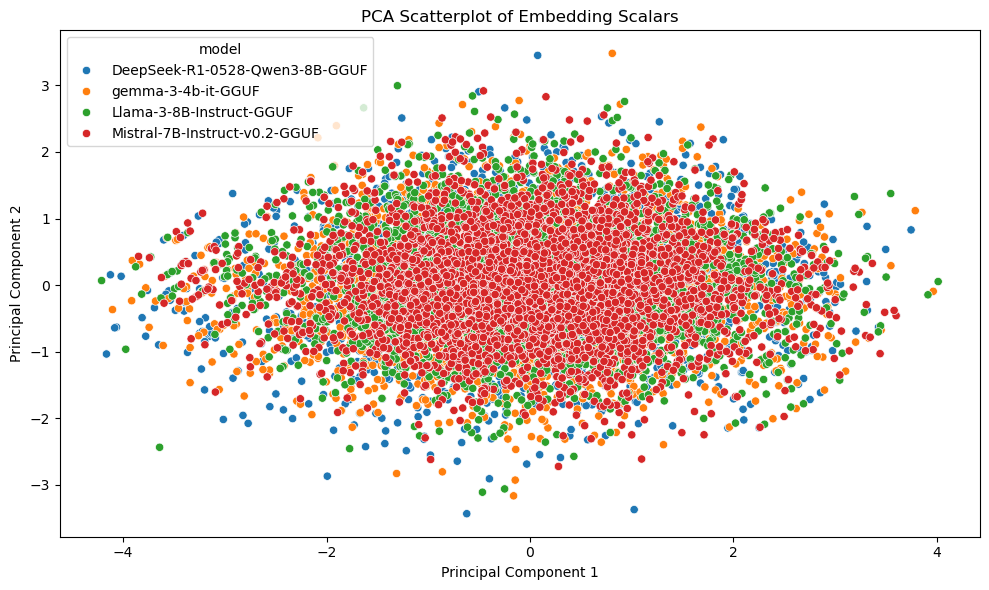

In [16]:
scalars = df[['embedding_reference_scalar', 'embedding_generated_scalar']].values
scalars = StandardScaler().fit_transform(scalars)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scalars)
df['pca1'] = pca_result[:, 0]
df['pca2'] = pca_result[:, 1]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='model')
plt.title("PCA Scatterplot of Embedding Scalars")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.savefig(os.path.join(overall_images_dir, "pca_scatterplot.png"))
plt.show()
plt.close()

#### Optional: Correlation Matrix of Similarity & Scalars

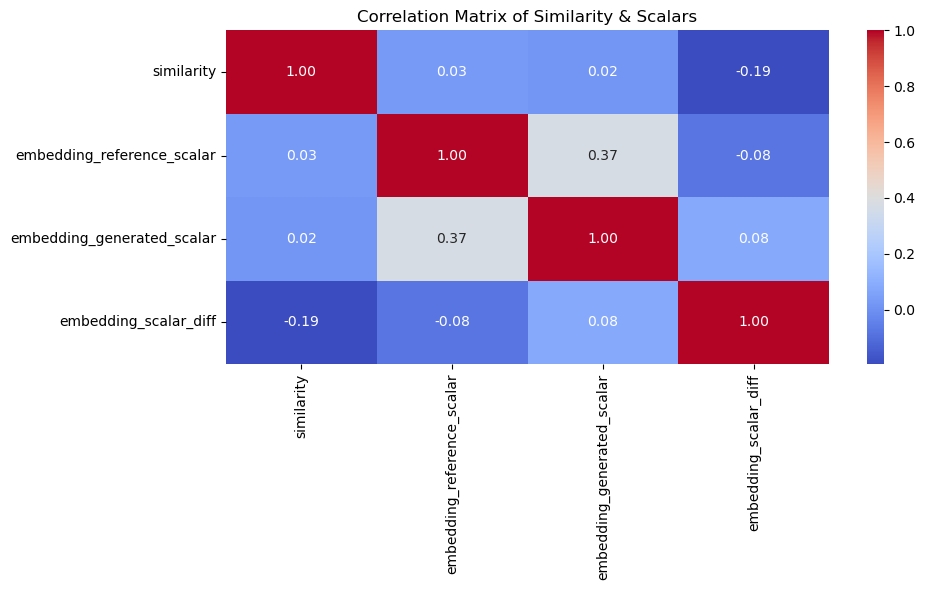

In [17]:
plt.figure(figsize=(10, 6))
corr_matrix = df[['similarity', 'embedding_reference_scalar', 'embedding_generated_scalar', 'embedding_scalar_diff']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Similarity & Scalars")
plt.tight_layout()
plt.savefig(os.path.join(overall_images_dir, "correlation_matrix.png"))
plt.show()
plt.close()

### Set up extra Dataframe to consider how often the same context (= patient input) occured

This necessity was overlooked initially and not saved in the combined model results.

Thus the context had to be gathered from the initial datafile.

In [19]:
# Load JSONL-style conversation file (NOT PROVIDED, BUT LINKED IN THIS REPORISTORY!!)
with open("mental_health_counseling_conversations.json", "r") as f:
    data = [json.loads(line) for line in f]
# Map index to actual context string
index_to_context = {i: row["Context"] for i, row in enumerate(data)}
df["Context"] = df["index"].map(index_to_context)
# Assign unique context IDs
unique_contexts = df["Context"].drop_duplicates().reset_index(drop=True)
context_to_id = {ctx: i for i, ctx in enumerate(unique_contexts)}
df["context_id"] = df["Context"].map(context_to_id)

# === Compute Context-Level Statistics for visualizations ===
context_stats = df.groupby("context_id")["similarity"].agg(["mean", "std"]).reset_index()
context_stats = context_stats.rename(columns={"mean": "similarity_mean", "std": "similarity_std"})
sorted_stats = context_stats.sort_values(by="similarity_mean", ascending=False).reset_index(drop=True)

# # (Optional) Save final DataFrame with context IDs and stats
# df.to_csv("combined_model_with_context_ids.csv", index=False)
# context_stats.to_csv("contextwise_similarity_summary.csv", index=False)

#### Create a bar plot showing similarity between local models and the human response (mean ± SD) for the different context (for now across all 4 models)

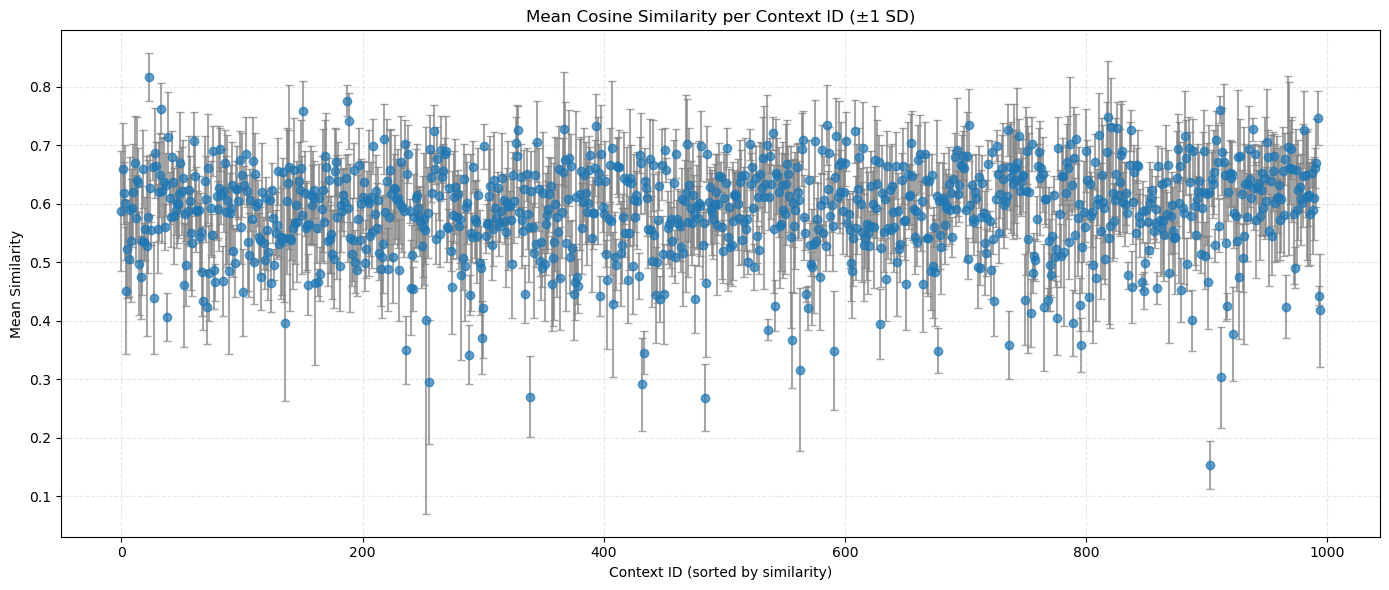

In [20]:
plt.figure(figsize=(14, 6))
plt.errorbar(
    x=sorted_stats["context_id"],
    y=sorted_stats["similarity_mean"],
    yerr=sorted_stats["similarity_std"],
    fmt='o',
    ecolor='gray',
    capsize=3,
    alpha=0.7
)
plt.title("Mean Cosine Similarity per Context ID (±1 SD)")
plt.xlabel("Context ID (sorted by similarity)")
plt.ylabel("Mean Similarity")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(context_comparison_dir, "contextwise_similarity_errorbar_acrossModels.png"))
plt.show()
plt.close()

#### Create Histogram of mean similarity between local models and the human response (across all 4 models)

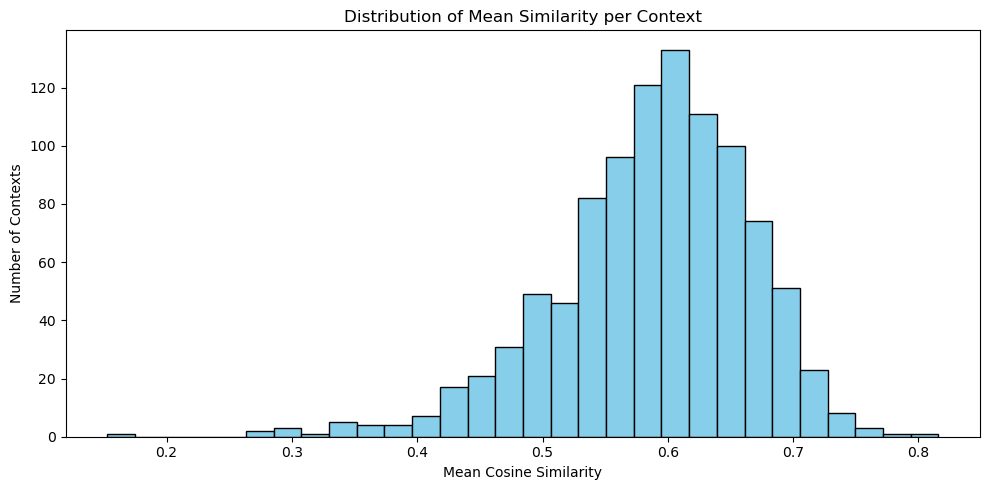

In [21]:
plt.figure(figsize=(10, 5))
plt.hist(context_stats["similarity_mean"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Mean Similarity per Context")
plt.xlabel("Mean Cosine Similarity")
plt.ylabel("Number of Contexts")
plt.tight_layout()
plt.savefig(os.path.join(context_comparison_dir, "contextwise_similarity_hist_acrossModels.png"))
plt.show()
plt.close()

#### Create Histogram of standard deviation of the similarity between local models and the human response (across all 4 models)

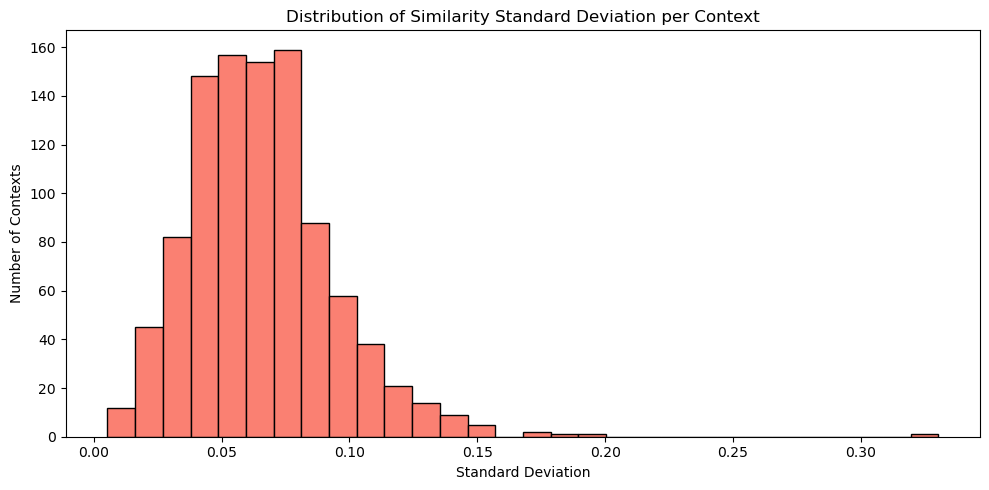

In [22]:
plt.figure(figsize=(10, 5))
plt.hist(context_stats["similarity_std"], bins=30, color="salmon", edgecolor="black")
plt.title("Distribution of Similarity Standard Deviation per Context")
plt.xlabel("Standard Deviation")
plt.ylabel("Number of Contexts")
plt.tight_layout()
plt.savefig(os.path.join(context_comparison_dir, "contextwise_similarity_std_hist_acrossModels.png"))
plt.show()
plt.close()

##### Repeat the previous 3 plots, but now for each of the 4 models individually

In [23]:
# Process per model
for model in df["model_name"].unique():
    df_model = df[df["model_name"] == model]
    
    # Compute context-level similarity stats for this model
    stats = df_model.groupby("context_id")["similarity"].agg(["mean", "std"]).reset_index()
    stats = stats.rename(columns={"mean": "similarity_mean", "std": "similarity_std"})
    sorted_stats = stats.sort_values(by="similarity_mean", ascending=False).reset_index(drop=True)
    
    model_tag = model.split("/")[-1].replace("-", "_").replace(" ", "_")

    # 1. Error bar plot
    plt.figure(figsize=(14, 6))
    plt.errorbar(
        x=sorted_stats["context_id"],
        y=sorted_stats["similarity_mean"],
        yerr=sorted_stats["similarity_std"],
        fmt='o', ecolor='gray', capsize=3, alpha=0.7
    )
    plt.title(f"{model_tag} – Mean Similarity per Context ID (±1 SD)")
    plt.xlabel("Context ID (sorted by similarity)")
    plt.ylabel("Mean Similarity")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"context_comparison/{model_tag}_errorbar_similarity.png")
    plt.close()

    # 2. Histogram of mean similarities
    plt.figure(figsize=(10, 5))
    plt.hist(stats["similarity_mean"], bins=30, color="skyblue", edgecolor="black")
    plt.title(f"{model_tag} – Histogram of Mean Similarities")
    plt.xlabel("Mean Cosine Similarity")
    plt.ylabel("Number of Contexts")
    plt.tight_layout()
    plt.savefig(f"context_comparison/{model_tag}_hist_mean_similarity.png")
    plt.close()

    # 3. Histogram of std deviations
    plt.figure(figsize=(10, 5))
    plt.hist(stats["similarity_std"], bins=30, color="salmon", edgecolor="black")
    plt.title(f"{model_tag} – Histogram of Similarity Std Dev")
    plt.xlabel("Standard Deviation")
    plt.ylabel("Number of Contexts")
    plt.tight_layout()
    plt.savefig(f"context_comparison/{model_tag}_hist_std_similarity.png")
    plt.close()

### Since some contexts appear more often than others in the datafile, the following plots weigh the statistics regarding the amount of their frequency and show the initial visualizations based on that

In [24]:
context_counts = df["context_id"].value_counts().to_dict()
df["context_weight"] = df["context_id"].map(lambda x: 1 / context_counts[x])



#### KDE Plot: mean similarity within a context of local model and human response 

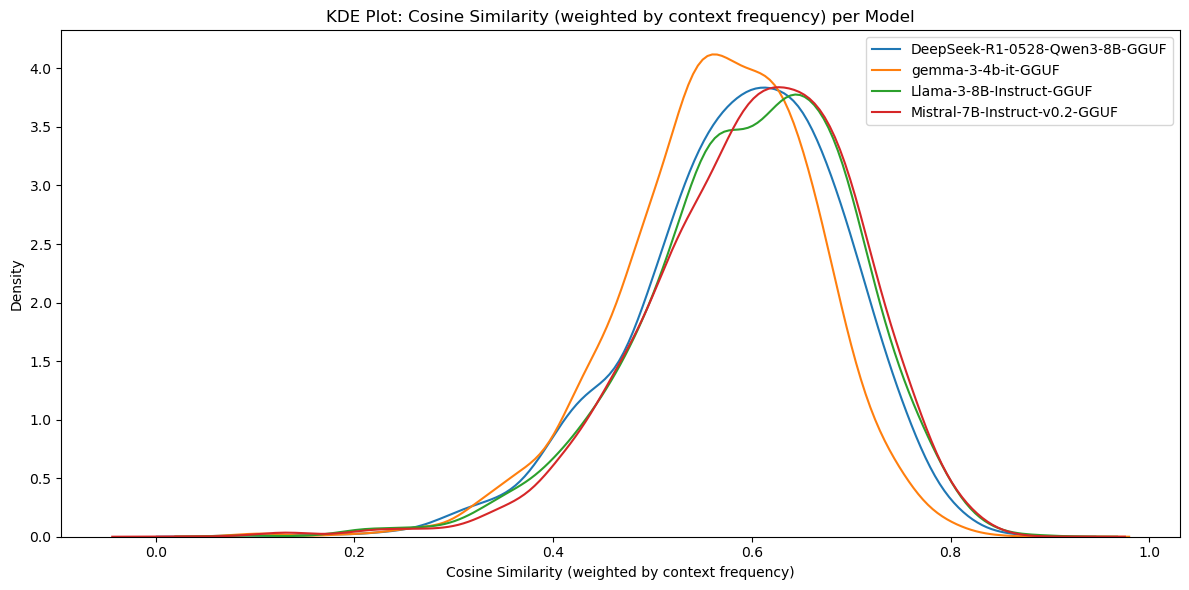

In [25]:
plt.figure(figsize=(12, 6))
for model in df["model_name"].unique():
    subset = df[df["model_name"] == model]
    sns.kdeplot(data=subset, x="similarity", weights=subset["context_weight"], label=model.split("/")[-1])
plt.title("KDE Plot: Cosine Similarity (weighted by context frequency) per Model")
plt.xlabel("Cosine Similarity (weighted by context frequency)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig("weighted_Context/kde_weighted_similarity.png")
plt.show()
plt.close()

#### Bar Plot: mean similarity across context (based on the mean similarity within a context) of local models and human response

C:\Users\gersc\AppData\Local\Temp\ipykernel_1928\373219463.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  means = df.groupby("model_name").apply(
C:\Users\gersc\AppData\Local\Temp\ipykernel_1928\373219463.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stds = df.groupby("model_name").apply(


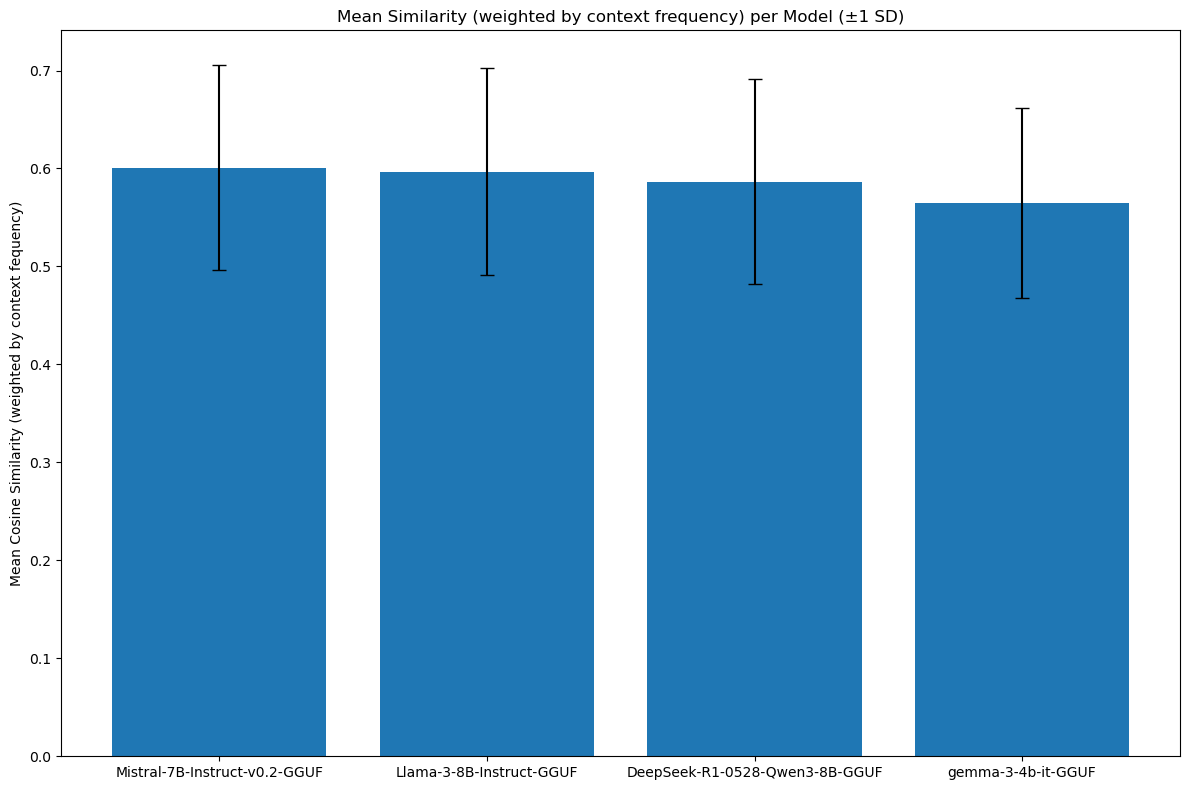

In [26]:
means = df.groupby("model_name").apply(
    lambda x: np.average(x["similarity"], weights=x["context_weight"])
).reset_index(name="weighted_mean")

stds = df.groupby("model_name").apply(
    lambda x: np.sqrt(np.cov(x["similarity"], aweights=x["context_weight"]))
).reset_index(name="weighted_std")

stats = pd.merge(means, stds, on="model_name")
stats["label"] = stats["model_name"].apply(lambda x: x.split("/")[-1])

plt.figure(figsize=(12, 8))
plt.bar(stats["label"], stats["weighted_mean"], yerr=stats["weighted_std"], capsize=5)
plt.title("Mean Similarity (weighted by context frequency) per Model (±1 SD)")
plt.ylabel("Mean Cosine Similarity (weighted by context fequency)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("weighted_Context/bar_weighted_mean_similarity.png")
plt.show()
plt.close()

#### Box Plot: mean similarity across context (based on the mean similarity within a context) of local models and human response

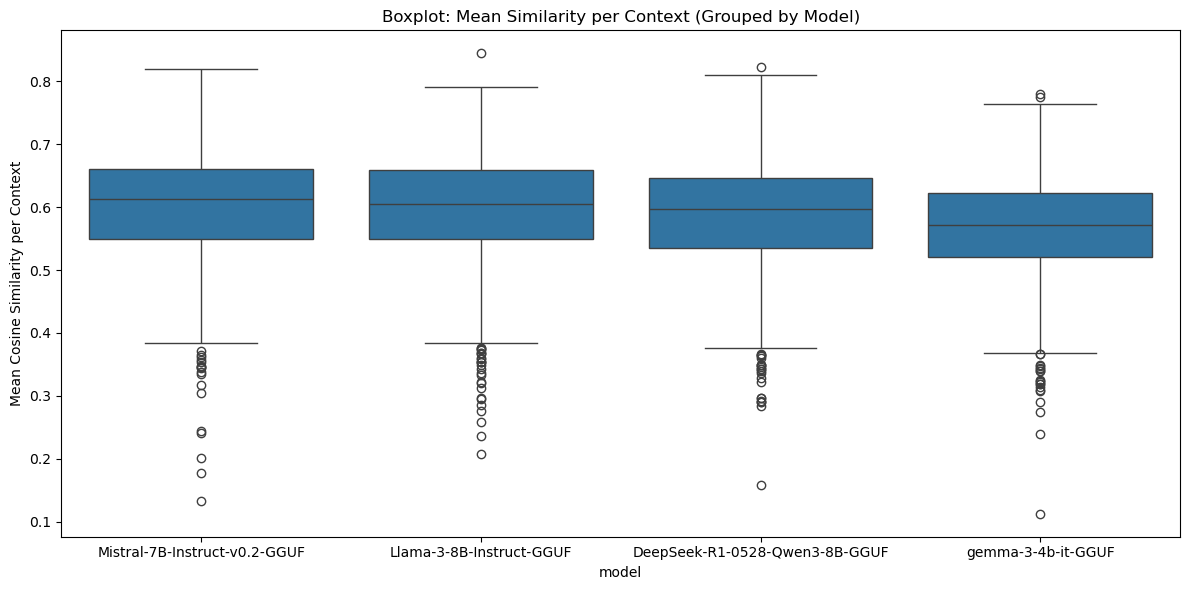

In [27]:
# 1. Compute mean similarity per context_id and model
context_level = df.groupby(["model_name", "context_id"])["similarity"].mean().reset_index()

# 2. Extract short model labels
context_level["model"] = context_level["model_name"].apply(lambda x: x.split("/")[-1])

# 3. Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=context_level, x="model", y="similarity")
plt.title("Boxplot: Mean Similarity per Context (Grouped by Model)")
plt.ylabel("Mean Cosine Similarity per Context")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("weighted_Context/boxplot_context_mean_similarity_per_model.png")
plt.show()


#### Violin Plot: mean similarity across context (based on the mean similarity within a context) of local models and human response

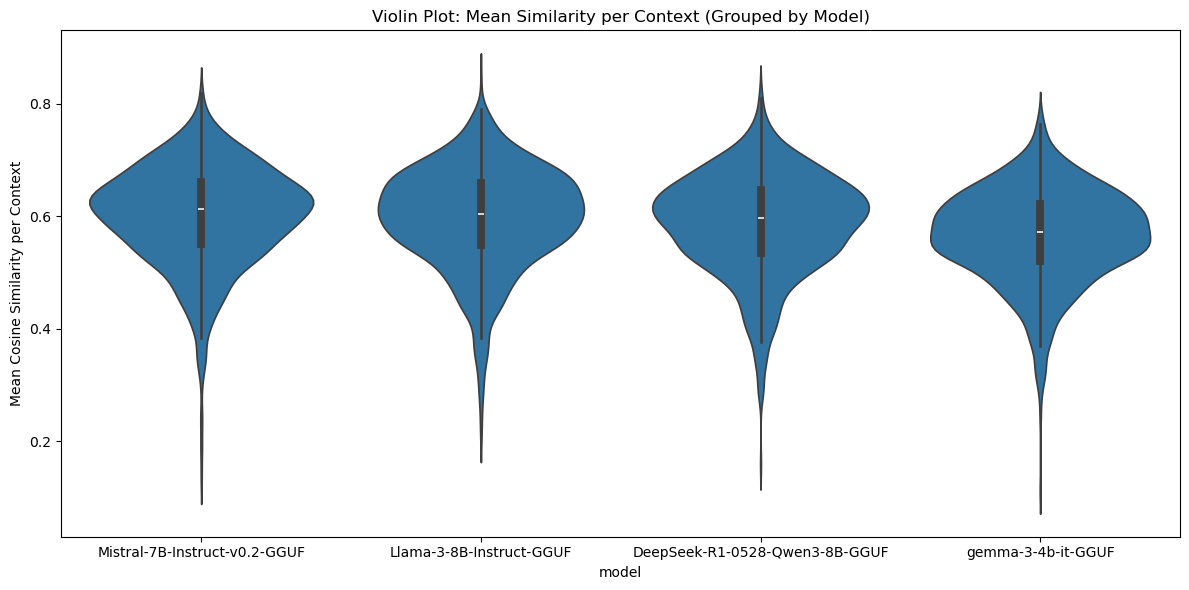

In [28]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=context_level, x="model", y="similarity")
plt.title("Violin Plot: Mean Similarity per Context (Grouped by Model)")
plt.ylabel("Mean Cosine Similarity per Context")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("weighted_Context/violin_context_mean_similarity_per_model.png")
plt.show()


### Lastly, visualize the human variability for contexts that appeared more than 2 times

As this was initially not considered properly, the embeddings of the human responses were not saved in the initial "combined_model_comparison.csv" file and had to be gathered from a different file where the embeddings were saved additionally. This file can not be made accessible on GitHub due to file size limitations on GitHub. Please see the commented code-block below to retrace how "within_human_similarity.csv" was created.
Note: Since the human response was the same for all models, it didn´t matter from which "results_with_embeddings_*.json" (there exist 4 such files for each model) file this information was retrieved from.

In [17]:
# # === Step 1: Load JSONL File ===
# with open("results_with_embeddings_second-state_Llama-3-8B-Instruct-GGUF.json", "r") as f:
#     data = json.load(f)
# # === Step 2: Build DataFrame with context and reference embedding ===
# records = []
# for d in data:
#     records.append({
#         "context": d["context"],
#         "embedding_reference": d["embedding_reference"]
#     })
# df = pd.DataFrame(records)
# # === Step 3: Group by context ===
# grouped = df.groupby("context")["embedding_reference"].apply(list).reset_index()
# # Filter out contexts with < 2 responses
# grouped = grouped[grouped["embedding_reference"].apply(len) >= 3].copy()
# # === Step 4: Compute mean pairwise cosine similarity per context ===
# def mean_pairwise_cosine(embeddings):
#     if len(embeddings) < 2:
#         return np.nan, np.nan  # Not enough for pairwise
#     arr = np.array(embeddings)
#     sim_matrix = cosine_similarity(arr)
#     pairs = list(combinations(range(len(arr)), 2))
#     sims = [sim_matrix[i, j] for i, j in pairs]
#     return np.mean(sims), np.std(sims)
# # Apply to each group
# grouped[["similarity_mean", "similarity_std"]] = grouped["embedding_reference"].apply(
#     lambda x: pd.Series(mean_pairwise_cosine(x))
# )
# # Drop groups with only one response
# grouped = grouped.dropna()

# grouped.to_csv("within_human_similarity.csv", index=False)

grouped = pd.read_csv("within_human_similarity.csv")

#### Within-Context Similarity between different human responses per context (mean +/- SD) 

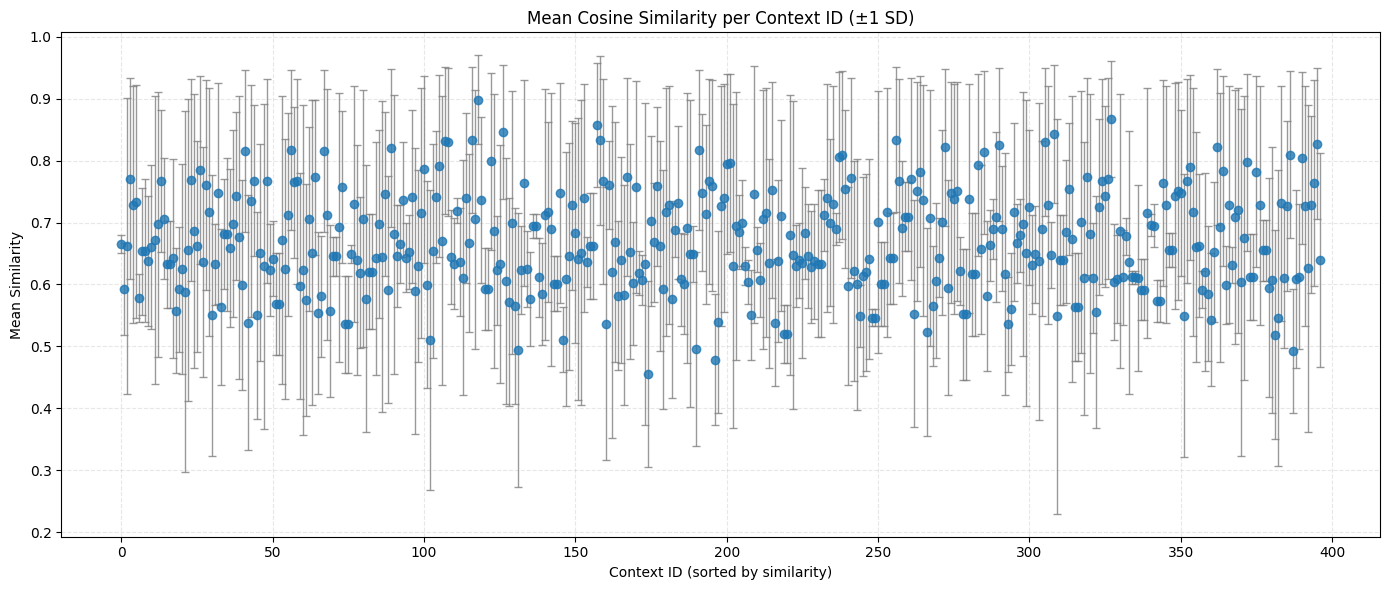

In [18]:
plt.figure(figsize=(14, 6))
plt.errorbar(
    x=range(len(grouped)),
    y=grouped["similarity_mean"],
    yerr=grouped["similarity_std"],
    fmt='o',
    ecolor='gray',
    elinewidth=1,
    capsize=3,
    alpha=0.8
)
plt.title("Mean Cosine Similarity per Context ID (±1 SD)")
plt.xlabel("Context ID (sorted by similarity)")
plt.ylabel("Mean Similarity")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("human_variability/plot_mean_similarity_per_context_with_errorbars.png")
plt.show()

#### Histogram of Within-Context Similarity between different human responses 

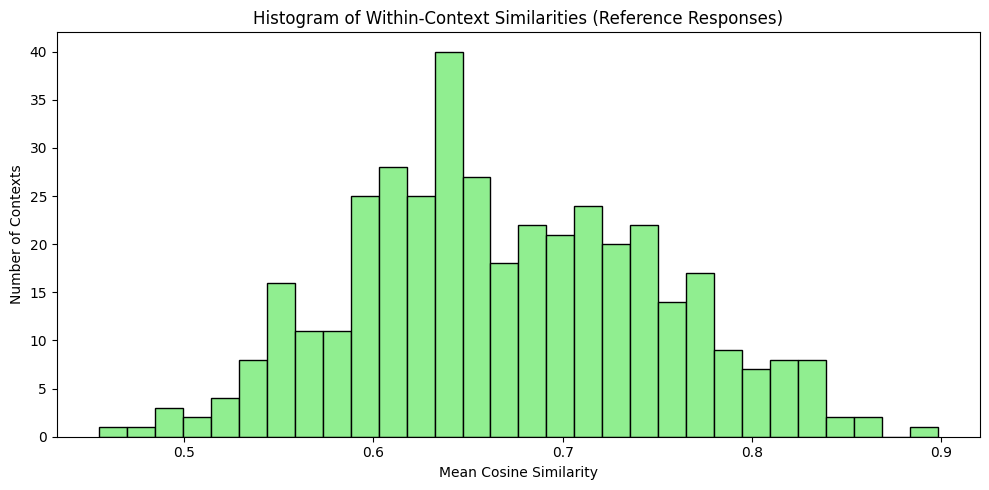

In [19]:
plt.figure(figsize=(10, 5))
plt.hist(grouped["similarity_mean"], bins=30, color="lightgreen", edgecolor="black")
plt.title("Histogram of Within-Context Similarities (Reference Responses)")
plt.xlabel("Mean Cosine Similarity")
plt.ylabel("Number of Contexts")
plt.tight_layout()
plt.savefig("human_variability/plot_reference_within_context_hist.png")
plt.show()

#### Violin-Plot of Within-Context Similarity between different human responses 

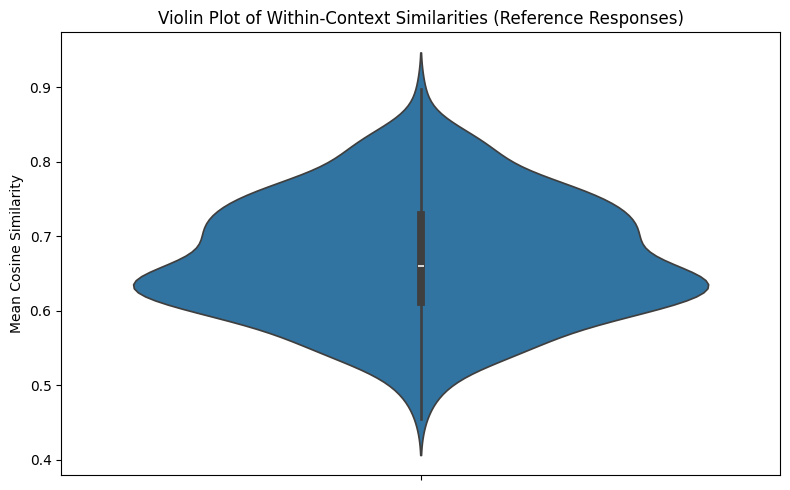

In [20]:
plt.figure(figsize=(8, 5))
sns.violinplot(y=grouped["similarity_mean"])
plt.title("Violin Plot of Within-Context Similarities (Reference Responses)")
plt.ylabel("Mean Cosine Similarity")
plt.tight_layout()
plt.savefig("human_variability/plot_reference_within_context_violin.png")
plt.show()